In [1]:
%load_ext tensorboard

In [2]:
import LayerCombination_NCHW as LC
from tensorflow.keras.layers import Input, concatenate, Add, Conv2D, BatchNormalization
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.math import sigmoid
import os
import numpy as np
from data_generator_JSON import DataGenerator
from datetime import datetime
from tensorflow.keras.utils import plot_model
import datetime

In [3]:
def gen_file_list(path):
    file_list = os.listdir(path)
    file_list = sorted(file_list)
    for c, files in enumerate(file_list):
        file_list[c] = os.path.join(path, files)
    return file_list

def check_folder_exist(folder):
    if not os.path.exists(folder):   # check the path
        os.makedirs(folder)          # if not exis, create

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.95
    epochs_drop = 10
    lrate = initial_lrate * tf.math.pow(drop, tf.math.floor((1+epoch)/epochs_drop))
    tf.summary.scalar('learning rate', data=lrate, step=epoch)
    return lrate

In [4]:
def custom_binary_crossentropy(y_true, y_pred):
    epsilon = 10e-7   
    loss = - (1/(7*320*256))*tf.math.reduce_sum(y_true * tf.math.log(y_pred+epsilon) + (1 - y_true) * tf.math.log(1 - y_pred+epsilon))
    return loss

def custom_mean_squared(y_true, y_pred):
    loss = (1/(7*320*256))*tf.math.reduce_sum((y_true - y_pred)**2)
    return loss

In [5]:
t = datetime.datetime.now()

In [6]:
batch_size = 5
train_aug = 0.5
epoch = 500
loss_mode = 'double'
decay_mode = 'default'
lr = 0.001
decay = 1e-1
momentum = 0.098
rd = 5
sigma = 10
time_stamp = t.strftime('%m')+'_'+t.strftime('%d')+'_'+t.strftime('%H')+'_'+t.strftime('%M')
model_name = 'MIMED_rd'+str(rd)+'_sig'+str(sigma)+'_'+time_stamp

# model_name = 'debug'
print(model_name)

# input will automatically resize to [256, 320]
input_shape = [3, 256, 320] 

mimed_rd5_sig_10_09_24_18_42


In [7]:
raw_list = gen_file_list('/tf/mount/Dataset/mimed/Dataset_15_09/JPEGImages/train')
test_raw_list = gen_file_list('/tf/mount/Dataset/mimed/Dataset_15_09/JPEGImages/test')

json_list = gen_file_list('/tf/mount/Dataset/mimed/Dataset_15_09/Annotations/train')
test_json_list = gen_file_list('/tf/mount/Dataset/mimed/Dataset_15_09/Annotations/train')


train_generator = DataGenerator(raw_list, 
                                json_list,
                                input_shape=input_shape,
                                batch_size=batch_size,
                                sigma=sigma,
                                rd=rd,
                                shuffle=True,
                                aug_proba=train_aug)

test_generator = DataGenerator(test_raw_list,
                               test_json_list,
                               input_shape=input_shape,
                               batch_size=batch_size,
                               sigma=sigma,
                               rd=rd,
                               shuffle=True,
                               aug_proba=False)

In [8]:
x = Input(shape=input_shape)

# Detection subnetwork
# first CBR layer combination
x_shape = x.get_shape()
down_1 = LC.CBR(x,
                [x_shape[0], x_shape[1], x_shape[2], 64],
                kernel_size=[3, 3])
# down sampling
down_2 = LC.down_sample(down_1)
down_3 = LC.down_sample(down_2)
down_4 = LC.down_sample(down_3)
down_5 = LC.down_sample(down_4)

# up sampling
up_1 = LC.up_sample(down_5, down_4)
up_2 = LC.up_sample(up_1, down_3)
up_3 = LC.up_sample(up_2)
up_4 = LC.up_sample(up_3)

# last CBS layer combination of detection sub network
y1, y2 = LC.out_branch(up_4, 4, 3)
y_dec_out = concatenate([y1, y2], axis=1, name='y_dec_out')

# skip connection from x
xb = BatchNormalization()(x)
y_dec_in = concatenate([y_dec_out, xb], axis=1)

# skip = Conv2D(filters=9,
#               kernel_size=[1, 1],
#               strides=[1, 1],
#               padding='same',
#               data_format='channels_last')(x)
# skip = BatchNormalization()(skip)
# skip = concatenate([y_dec_out, x], axis=3)

# Regression subnetwork
y = LC.reg_sub(y_dec_in)

In [9]:
checkpoint_name = 'model_'+model_name + '_aug_'+str(train_aug) +'_decay_'+decay_mode
checkpoint_path = 'tf_data/checkpoint/'+checkpoint_name
checkpoint_dir = os.path.dirname(checkpoint_path)

log_dir = "tf_data/logs/fit/" + checkpoint_name
file_writer = tf.summary.create_file_writer(log_dir + "/metrics")
file_writer.set_as_default()



# Checkpoint
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                         verbose=1, 
                                                         save_freq=int(len(raw_list)/batch_size)*10)

# Tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch='{},{}'
                                                      .format(int(len(raw_list)/batch_size)*2,
                                                      int(len(raw_list)/batch_size)*2+10))

# Early stopping
early_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', 
                                                  min_delta=0.0001,
                                                  patience=50,
                                                  restore_best_weights=True)
# learning rate decay
lrate_callback = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [10]:
# load h5
# model = tf.keras.models.load_model('./rd34.h5', compile=False)

# fresh new
model = Model(inputs=x, outputs=[y_dec_out, y])
model.save_weights(checkpoint_path.format(epoch=0))

# load checkpoint
# latest = tf.train.latest_checkpoint(checkpoint_dir)
# model.load_weights(latest)


In [11]:
model.summary()
plot_model(model, to_file="./{}.png".format(model_name), show_shapes=True, expand_nested=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3, 256, 320) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 3, 256, 320)  84          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 3, 256, 320)  12          conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 3, 256, 320)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [12]:
if loss_mode == 'double':
    loss_func = {
        'y_dec_out':custom_binary_crossentropy,
        'y':custom_mean_squared
    }
else:
    loss_func = custom_binary_crossentropy

In [13]:
# %tensorboard --logdir logs/fit --bind all

In [14]:
if decay_mode == 'default':
    sgd = tf.keras.optimizers.SGD(learning_rate=lr, decay=decay, momentum=momentum, nesterov=True)
    callback = [checkpoint_callback, tensorboard_callback , early_callback]

elif decay_mode == 'defined':
    sgd = tf.keras.optimizers.SGD(learning_rate=0, momentum=momentum, nesterov=True)
    callback = [checkpoint_callback, tensorboard_callback , early_callback, lrate_callback]

model.compile(optimizer='sgd', loss=loss_func)
model.fit(train_generator,
          epochs=epoch,
          callbacks=callback,
          validation_data=test_generator,
          validation_freq=15)



Epoch 1/500
389/389 [==============================] - 184s 474ms/step - loss: 6.7409 - y_dec_out_loss: 2.4131 - y_loss: 4.3278
Epoch 2/500
389/389 [==============================] - 176s 453ms/step - loss: 4.5947 - y_dec_out_loss: 1.2337 - y_loss: 3.3610
Epoch 3/500
389/389 [==============================] - 172s 441ms/step - loss: 3.4356 - y_dec_out_loss: 0.8080 - y_loss: 2.6276
Epoch 4/500
389/389 [==============================] - 172s 443ms/step - loss: 2.6510 - y_dec_out_loss: 0.6011 - y_loss: 2.0500
Epoch 5/500
180/389 [============>.................] - ETA: 1:35 - loss: 2.2306 - y_dec_out_loss: 0.5052 - y_loss: 1.7254

KeyboardInterrupt: 

In [16]:
# save the model
# model.save('saved_model/'+checkpoint_name+'.h5')

# import test image
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
pre = cv2.imread('/tf/mount/Dataset/mimed/Dataset_15_09/JPEGImages/test/003377.png')
pre = cv2.resize(pre,(320, 256))
pre_array = tf.transpose(pre, [2,0,1])
pre_array = tf.reshape(pre_array,(1,3,256,320))

# run time test
import time
start = int(round(time.time()*1000))
m = model.predict(pre_array)
end = int(round(time.time()*1000))
print('run time of inferencing', end-start)

# save the results
check_folder_exist('results_output/'+checkpoint_name)
m_save = np.concatenate((m[0],m[1]),3)
np.save('results_output/'+checkpoint_name+'/predict.npy',m_save)

m[0] = tf.transpose(m[0], [0,2,3,1])
m[1] = tf.transpose(m[1], [0,2,3,1])

run time of inferencing 1788


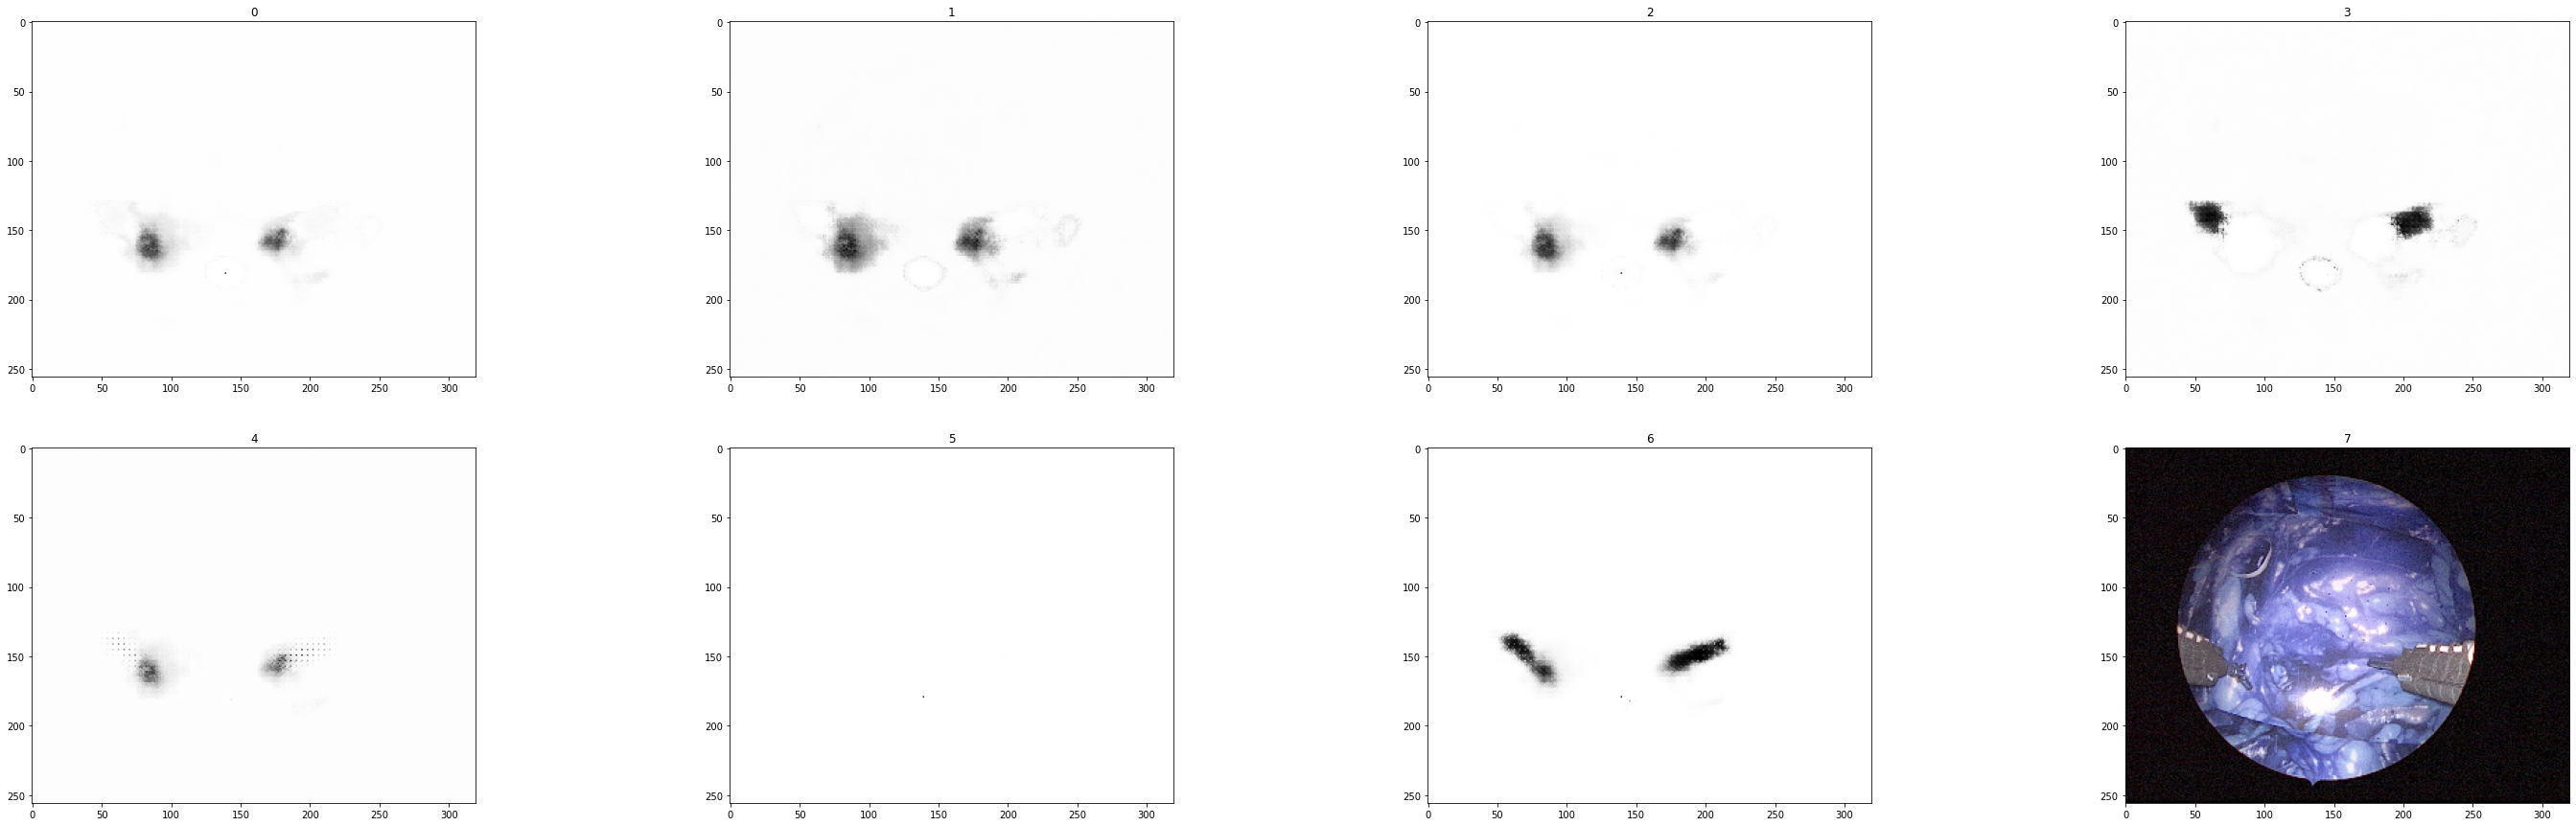

In [17]:
# plot the results
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img 
import matplotlib.cm as cm



fig=plt.figure(figsize=(50, 15))
columns = 4
rows = 2
for i in range(0, columns*rows-1):
    fig.add_subplot(rows, columns, i+1).set_title(i)
    #plt.imshow(pre)
    plt.imshow(m[0][0, :, :, i],cmap=cm.binary)#, alpha=0.2)

fig.add_subplot(rows, columns, 8).set_title(7)
plt.imshow(pre,cmap=cm.binary)
plt.show()

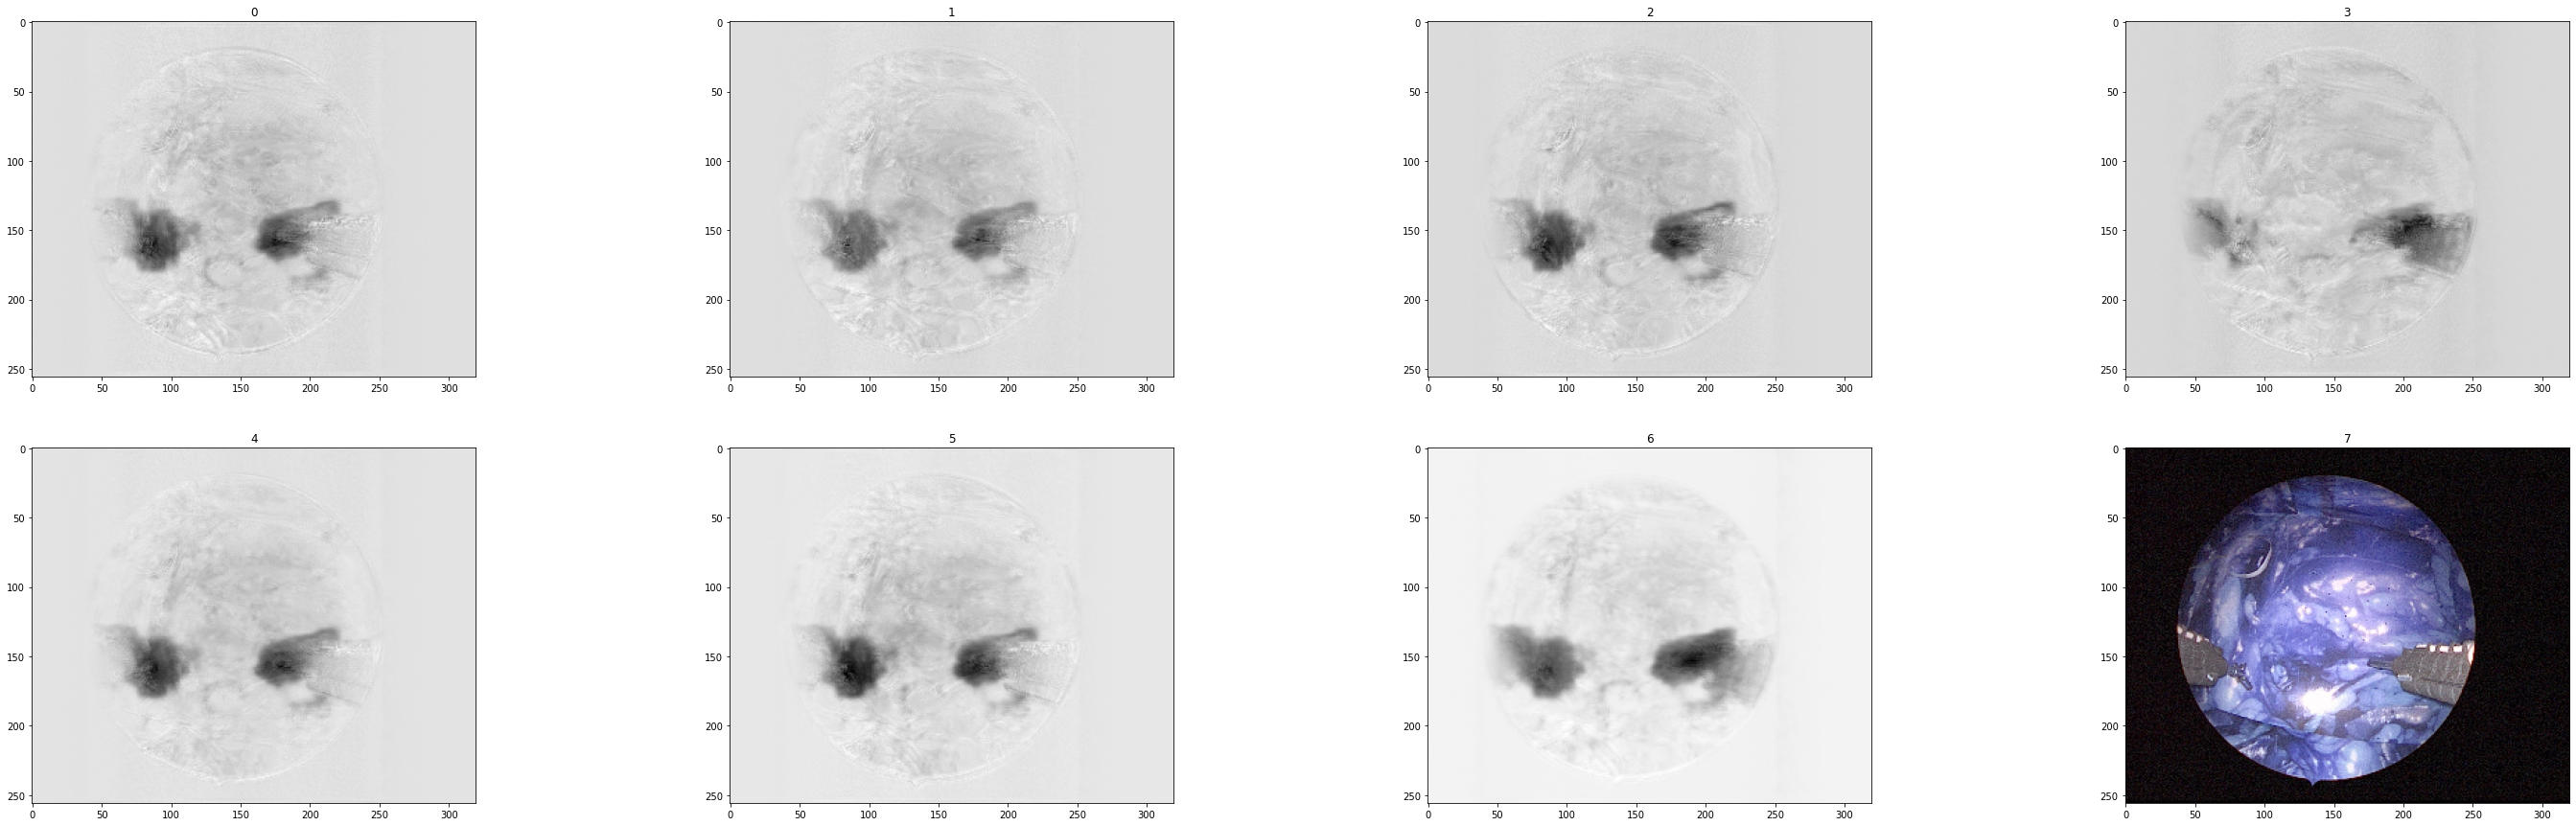

In [18]:
fig=plt.figure(figsize=(50, 15))

for i in range(0, columns*rows-1):
    fig.add_subplot(rows, columns, i+1).set_title(i)
    #plt.imshow(pre)
    plt.imshow(m[1][0, :, :, i],cmap=cm.binary)#, alpha=0.2)

fig.add_subplot(rows, columns, 8).set_title(7)
plt.imshow(pre,cmap=cm.binary)
plt.show()

In [16]:
! pwd

/tf/project/instrument-tracking/src
